In [1]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [2]:
def step(t, dt):
    t = t + dt
    return t

In [3]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="grey", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')

In [4]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [5]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0

        if self.view_max > end_row:
            self.view_max = end_row
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [6]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [43]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 4.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.])
        self.y_edges_f     = np.array([0.,0.])
        self.z_edges_f     = np.array([0.,0.])
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = 5.  #1.
        self.a_max         = 15. #10. 
        self.d_max         = 15. #10.
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        can_reach   = 0               # start with the possibility that a fruit cannot be reached
        epsilon     = 0.001           # allowable error when reaching fruit 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
#                 print("AND AFTER?", self.retractFlag)
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.q_a[0] < self.q_f[0]-0.001:  
#             print("")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("edges in X:", self.x_edges_f, "edges in Y:", self.y_edges_f, "edges in Z:", self.z_edges_f)

#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("arm location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#         print("")
#         print("Goals reached:", self.goal_r)
#         print("retracting:", self.retractFlag)
#         print("can it reach?:", can_reach)
#         print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0.
                
            elif self.retractFlag == 0:
                self.tx        = 0.
                self.free      = 1 
                self.x_move    = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0] = 0
                self.goal_r[1] = 0
                self.goal_r[2] = 0
        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0) 
        self.z.adjInit(self.q_a[2], 0)
        
        self.trapTimes()
            
        # maybe start time here? => evalulate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [44]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [57]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 15.  # end of the row
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [58]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.01])       # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [59]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [60]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [61]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of arm in vehicle frame? => need to figure out how to set these when there are >1 arms
q_a_new = np.array([0.,0.,0.]) 

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        q_a_new[0] = q_a[0]             # doesn't change right now
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [62]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))
    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
#     picture.cameraStep(end_row, q_v[1], sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys
                
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000) #+2
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)
                        ### make sure there are available goals left in the b-tree at some point
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

                ## look into B-Trees 
                ## https://ebrary.net/25936/computer_science/b-tree_organization
                ## https://cstack.github.io/db_tutorial/parts/part7.html

                ## what happens when there are gaps between trees/fruits => right now it would freeze? => maybe not...
                ## => right now they freeze when they hit that 

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(a[0,0].x_edges_f[0]))
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 6.3 9.8678696059 0
start, end, start velocity: 6.0 5.3231695488 0
start, end, start velocity: 1.5 1.1919865482 0
start, end, start velocity: 6.3 9.9191284757 0
start, end, start velocity: 9.0 7.5732524703 0
start, end, start velocity: 1.5 1.4549112491 0
start, end, start velocity: 6.3 9.0836432909 0
start, end, start velocity: 12.0 10.794768294 0
start, end, start velocity: 1.5 0.9577824011 0
start, end, start velocity: 6.3 7.8880462924 0
start, end, start velocity: 6.0 5.9278863172 0
start, end, start velocity: 4.5 4.2075675354 0
start, end, start velocity: 6.3 8.2155859972 0
start, end, start velocity: 9.0 7.5099152899 0
start, end, start velocity: 4.5 3.7314053709 0
start, end, start velocity: 6.3 7.7962720949 0
start, end, start velocity: 12.0 10.5610279055 0
start, end, start velocity: 4.5 4.0949260327 0
start, end, start velocity: 6.3 7.5979936552 0
start, end, start velocity: 6.0 6.0434705216 0
start, end, start velocity: 7.5 6.1161441163 0
start, end

start, end, start velocity: 7.527545185988853 6.3 0
start, end, start velocity: 9.026351101419372 6.3 0
start, end, start velocity: 8.216872043662914 6.3 0
start, end, start velocity: 6.830157008343873 6.3 0
start, end, start velocity: 8.53417078968188 6.3 0
start, end, start velocity: 7.233835876937137 6.3 0
start, end, start velocity: 6.300231611512071 7.7667841274 0
start, end, start velocity: 11.828626589156906 11.8454765652 0
start, end, start velocity: 8.575058645374753 7.3349015093 0
start, end, start velocity: 8.511185389655312 6.3 0
start, end, start velocity: 6.300060031830381 7.1250329818 0
start, end, start velocity: 7.701107706760627 7.7197088781 0
start, end, start velocity: 8.40759248024862 8.3982626737 0
start, end, start velocity: 9.837677895668564 6.3 0
start, end, start velocity: 7.610569225581155 6.3 0
start, end, start velocity: 6.300168720436589 7.8569085747 0
start, end, start velocity: 10.68760453188363 10.6924902246 0
start, end, start velocity: 4.4824599815710

start, end, start velocity: 8.047087957921173 6.3 0
start, end, start velocity: 6.300231340732063 8.3021382644 0
start, end, start velocity: 11.07741613019497 11.1025636232 0
start, end, start velocity: 3.488682513663045 3.477485045 0
start, end, start velocity: 6.30001804054736 6.9357649548 0
start, end, start velocity: 7.404631332709662 7.4376066872 0
start, end, start velocity: 7.03469489701792 7.3155241482 0
start, end, start velocity: 6.300211422266265 6.4259301825 0
start, end, start velocity: 7.791979418370797 7.8478658145 0
start, end, start velocity: 8.575208827086607 7.6788327735 0
start, end, start velocity: 9.864580477826687 6.3 0
start, end, start velocity: 9.08111839252978 6.3 0
start, end, start velocity: 7.849456934017297 6.3 0
start, end, start velocity: 6.300058240841854 9.3565883934 0
start, end, start velocity: 6.418031896370095 6.44303329 0
start, end, start velocity: 5.043079517442993 3.1146068912 0
start, end, start velocity: 6.935509303090101 6.3 0
start, end, s

start, end, start velocity: 8.395087262222841 6.3 0
start, end, start velocity: 6.300012036777941 7.7224076075 0
start, end, start velocity: 12.117699622556449 12.1272206276 0
start, end, start velocity: 7.739586999954495 7.1395436973 0
start, end, start velocity: 6.300134551076669 9.7746217813 0
start, end, start velocity: 5.802401771539292 5.8285859145 0
start, end, start velocity: 1.346098630690376 0.855563029 0
start, end, start velocity: 7.609398507438587 6.3 0
start, end, start velocity: 6.97764599317093 6.3 0
start, end, start velocity: 6.680174874273405 6.3 0
start, end, start velocity: 6.300269681858599 9.7717373544 0
start, end, start velocity: 7.9743263481858575 8.0225264527 0
start, end, start velocity: 1.307677759049841 1.0307362359 0
start, end, start velocity: 6.30009825475588 8.5783843692 0
start, end, start velocity: 11.287689532428267 11.3514658069 0
start, end, start velocity: 3.2171815947749556 3.214942428 0
start, end, start velocity: 6.300009573514558 6.9905282776

start, end, start velocity: 6.300138308212174 7.4952996361 0
start, end, start velocity: 8.452284829011878 8.558201391 0
start, end, start velocity: 8.601776467180724 6.7013160673 0
start, end, start velocity: 8.258463594651934 6.3 0
start, end, start velocity: 8.045541976681893 6.3 0
start, end, start velocity: 8.644166032073244 6.3 0
start, end, start velocity: 7.747542734611499 6.3 0
start, end, start velocity: 6.300032918790231 9.7810065184 0
start, end, start velocity: 8.167697809505045 8.1717457001 0
start, end, start velocity: 0.8868674438129721 1.0112443587 0
start, end, start velocity: 6.972783696475911 6.3 0
start, end, start velocity: 6.300258932252876 9.0757881807 0
start, end, start velocity: 5.878418320194283 5.8831005433 0
start, end, start velocity: 0.9231738423992824 0.6002939427 0
start, end, start velocity: 6.300006319511894 7.2697365358 0
start, end, start velocity: 12.290316657110504 12.3497232405 0
start, end, start velocity: 7.443893738465099 6.6190614046 0
start

start, end, start velocity: 7.147465155103335 6.3 0
start, end, start velocity: 7.472308289408108 6.3 0
start, end, start velocity: 8.955216464504357 6.3 0
start, end, start velocity: 6.300162035898094 9.2116435344 0
start, end, start velocity: 8.304657895105903 8.3155286282 0
start, end, start velocity: 1.64052068848122 0.8625541378 0
start, end, start velocity: 6.300261587916834 8.4523149408 0
start, end, start velocity: 11.643200334333661 11.6668870265 0
start, end, start velocity: 2.630647684240497 2.6346761271 0
start, end, start velocity: 6.300082954877624 7.5348314402 0
start, end, start velocity: 8.813294051687114 8.8202325854 0
start, end, start velocity: 6.66781765476062 6.3448542481 0
start, end, start velocity: 6.300055891844894 7.8381145569 0
start, end, start velocity: 8.392706953882461 8.4000537743 0
start, end, start velocity: 5.269052877971804 5.2747947104 0
start, end, start velocity: 6.300079875267812 7.3867662546 0
start, end, start velocity: 12.485659140222117 12.5

start, end, start velocity: 7.481495267992848 6.3 0
start, end, start velocity: 8.466545039160808 6.3 0
start, end, start velocity: 8.291153471272523 6.3 0
start, end, start velocity: 8.753586829322371 6.3 0
start, end, start velocity: 8.070455486789646 6.3 0
start, end, start velocity: 6.300006404680984 6.965092771 0
start, end, start velocity: 9.208275112496562 9.2397614633 0
start, end, start velocity: 7.398852081515932 6.8839762436 0
start, end, start velocity: 6.300176930574145 7.3606896441 0
start, end, start velocity: 11.866923478758707 11.8820124302 0
start, end, start velocity: 4.258502698989671 5.8728905758 0
start, end, start velocity: 6.300165450391188 8.8355059867 0
start, end, start velocity: 8.531036093203582 8.5328606554 0
start, end, start velocity: 3.3764735933272005 4.5662343198 0
start, end, start velocity: 8.962547103571543 6.3 0
start, end, start velocity: 6.300035868292744 8.6490604616 0
start, end, start velocity: 6.257948689271688 6.3585408717 0
start, end, sta

start, end, start velocity: 6.30016923108199 7.1187491971 0
start, end, start velocity: 9.327706065068815 9.3871786596 0
start, end, start velocity: 6.53954923140324 6.4928662589 0
start, end, start velocity: 8.593994381406109 6.3 0
start, end, start velocity: 6.3001181760388505 9.2163129092 0
start, end, start velocity: 8.844330848128658 9.0254388372 0
start, end, start velocity: 2.865480305177547 1.7554104063 0
start, end, start velocity: 6.30023608400927 8.3530679163 0
start, end, start velocity: 11.937627042475416 11.9478815409 0
start, end, start velocity: 4.698142087578902 3.0275792104 0
start, end, start velocity: 7.3379014926877835 6.3 0
start, end, start velocity: 7.118554094259778 6.3 0
start, end, start velocity: 6.300283599786818 9.3919441802 0
start, end, start velocity: 6.528459911521227 6.591081971 0
start, end, start velocity: 2.8012579779216042 2.8589673487 0
start, end, start velocity: 8.316643943668955 6.3 0
start, end, start velocity: 6.30013921251435 7.3379131754 0

start, end, start velocity: 7.19647742999184 6.3 0
start, end, start velocity: 6.3002061395949385 7.6655367021 0
start, end, start velocity: 13.195950909392531 13.2579958051 0
start, end, start velocity: 7.700806412419546 7.6524829516 0
start, end, start velocity: 9.186321996555982 6.3 0
start, end, start velocity: 6.300094254524522 6.6871015525 0
start, end, start velocity: 9.640826077373662 9.6802951908 0
start, end, start velocity: 6.145145291502751 6.4953365508 0
start, end, start velocity: 6.300144044894409 9.7752470513 0
start, end, start velocity: 9.15088431155603 9.259705796 0
start, end, start velocity: 1.6984953123468889 0.8016392527 0
start, end, start velocity: 6.300299598620747 7.852242141 0
start, end, start velocity: 11.978502215641964 11.9842215397 0
start, end, start velocity: 5.8923010679398935 4.6443445353 0
start, end, start velocity: 6.30010967251041 9.2860994689 0
start, end, start velocity: 6.682236339940186 6.7205522747 0
start, end, start velocity: 0.7116848874

start, end, start velocity: 6.300295373872289 7.9760058238 0
start, end, start velocity: 12.024801557505434 12.0388962407 0
start, end, start velocity: 5.104731429264823 4.5557222816 0
start, end, start velocity: 8.207133047022003 6.3 0
start, end, start velocity: 9.819185483836202 6.3 0
start, end, start velocity: 6.300243165345516 8.4518765259 0
start, end, start velocity: 12.167045511720698 12.1898152061 0
start, end, start velocity: 1.659109647680807 1.3858136003 0
start, end, start velocity: 6.300046903795219 7.150269511 0
start, end, start velocity: 13.421162597141592 13.4373429016 0
start, end, start velocity: 6.299996807737914 6.2898844337 0
start, end, start velocity: 6.853755138812802 6.3 0
start, end, start velocity: 6.300309883989562 7.5767722108 0
start, end, start velocity: 9.20858784572665 9.3751136838 0
start, end, start velocity: 5.143296706665249 4.062056229 0
start, end, start velocity: 6.300068565361538 6.5117638931 0
start, end, start velocity: 10.038332157173473 1

start, end, start velocity: 6.300313612899674 8.9634730017 0
start, end, start velocity: 9.584407375406295 9.5933745911 0
start, end, start velocity: 1.3212920494636853 1.7217417595 0
start, end, start velocity: 7.047844819590732 6.3 0
start, end, start velocity: 7.679588359598122 6.3 0
start, end, start velocity: 6.300053375913288 7.9370314874 0
start, end, start velocity: 9.584734523241208 9.5897325477 0
start, end, start velocity: 5.388850855740544 5.2688257352 0
start, end, start velocity: 9.242605980664713 6.3 0
start, end, start velocity: 6.300161897083183 7.02302673 0
start, end, start velocity: 12.487428806197382 12.4886415534 0
start, end, start velocity: 5.771786737838964 5.7800983747 0
start, end, start velocity: 6.300160371570942 7.7963013184 0
start, end, start velocity: 13.641260316971676 13.6881434855 0
start, end, start velocity: 6.617291635173475 7.5533608934 0
start, end, start velocity: 7.937029637935183 6.3 0
start, end, start velocity: 9.533483399118817 6.3 0
start

start, end, start velocity: 7.399455139119107 6.3 0
start, end, start velocity: 9.094401675777464 6.3 0
start, end, start velocity: 7.2060755263093 6.3 0
start, end, start velocity: 6.300008085835666 7.3136971216 0
start, end, start velocity: 10.211438405769915 10.2697787949 0
start, end, start velocity: 5.23383613824212 5.0607327412 0
start, end, start velocity: 7.587125199608072 6.3 0
start, end, start velocity: 8.527797814309151 6.3 0
start, end, start velocity: 9.179249888842799 6.3 0
start, end, start velocity: 6.300111966485911 9.7301875654 0
start, end, start velocity: 7.250458127274845 7.2932981744 0
start, end, start velocity: 0.37142166698126516 2.4670029682 0
start, end, start velocity: 6.300267840745625 7.2094226094 0
start, end, start velocity: 13.935648864975711 13.9560516354 0
start, end, start velocity: 7.023267851567869 7.253394267 0
start, end, start velocity: 6.300128827780354 7.2238520652 0
start, end, start velocity: 12.836781581495883 12.9140022141 0
start, end, s

start, end, start velocity: 7.705470402119909 6.3 0
start, end, start velocity: 6.994581904251217 6.3 0
start, end, start velocity: 6.300156820735491 7.8067666115 0
start, end, start velocity: 13.097895166620416 13.1161500123 0
start, end, start velocity: 4.5370853837687015 5.4753208867 0
start, end, start velocity: 6.300063351028801 9.1114351386 0
start, end, start velocity: 10.293755186638515 10.365609863 0
start, end, start velocity: 1.5646799164740495 0.4981928412 0
start, end, start velocity: 6.3003474693974235 7.6986306725 0
start, end, start velocity: 14.509954836594556 14.5249038655 0
start, end, start velocity: 7.00803599476781 7.5037392898 0
start, end, start velocity: 6.300227993924325 8.4014039995 0
start, end, start velocity: 10.378290780021938 10.3794248121 0
start, end, start velocity: 4.0481267204750795 4.0658212558 0
start, end, start velocity: 8.663253746821118 6.3 0
start, end, start velocity: 7.806624660245443 6.3 0
start, end, start velocity: 8.40139223944318 6.3 0

start, end, start velocity: 8.988903497270453 6.3 0
start, end, start velocity: 6.300273056775168 7.481684167 0
start, end, start velocity: 13.409139325272527 13.422274847 0
start, end, start velocity: 3.575370381074092 5.9500913903 0
start, end, start velocity: 7.877748606556281 6.3 0
start, end, start velocity: 6.30022193005209 8.8156435908 0
start, end, start velocity: 13.63273046386544 13.6359592262 0
start, end, start velocity: 2.1241739216517472 1.3327042018 0
start, end, start velocity: 6.300279891651553 7.8193329606 0
start, end, start velocity: 14.796805716170148 14.8142228806 0
start, end, start velocity: 6.670064152189652 8.0535597092 0
start, end, start velocity: 7.481677956766397 6.3 0
start, end, start velocity: 6.300006837073453 8.5352936201 0
start, end, start velocity: 13.42227235313802 13.4278962691 0
start, end, start velocity: 5.949844180209856 4.1290176848 0
start, end, start velocity: 8.815489374194765 6.3 0
start, end, start velocity: 7.819285956396401 6.3 0
star

start, end, start velocity: 7.814920427134393 6.3 0
start, end, start velocity: 9.022419252714222 6.3 0
start, end, start velocity: 6.300072822890251 9.0724282308 0
start, end, start velocity: 13.863137736180875 13.919784226 0
start, end, start velocity: 4.417704319036725 3.084709482 0
start, end, start velocity: 6.300224192524714 9.2248708224 0
start, end, start velocity: 13.90529753854688 13.9155868073 0
start, end, start velocity: 2.80028788306435 2.2410638736 0
start, end, start velocity: 9.072204676723375 6.3 0
start, end, start velocity: 9.224624356103854 6.3 0
start, end, start velocity: 6.30022204676476 7.977262027 0
start, end, start velocity: 13.919752571537355 13.9275237564 0
start, end, start velocity: 3.0847633729842587 4.6268599112 0
start, end, start velocity: 6.3002462435584246 9.15759135 0
start, end, start velocity: 13.915369142494619 13.9353105951 0
start, end, start velocity: 2.241206580069943 2.6924471721 0
start, end, start velocity: 7.9769916271991335 6.3 0
start

start, end, start velocity: 8.165101143658939 6.3 0
start, end, start velocity: 6.300151011434923 7.5009433044 0
start, end, start velocity: 14.369361922733459 14.3998258454 0
start, end, start velocity: 5.207963490367427 5.045250927 0
start, end, start velocity: 7.500813996822797 6.3 0
start, end, start velocity: 6.300129532898418 8.2717955882 0
start, end, start velocity: 14.399460653490667 14.4053841899 0
start, end, start velocity: 5.045509432911708 4.4907974587 0
start, end, start velocity: 8.271578927648738 6.3 0
start, end, start velocity: 6.300215789274734 7.9094835964 0
start, end, start velocity: 14.405383944723548 14.4308688215 0
start, end, start velocity: 4.490877079523835 5.3357743627 0
start, end, start velocity: 7.909393055326064 6.3 0
start, end, start velocity: 6.300089604065084 7.3576380739 0
start, end, start velocity: 14.430846538373107 14.4380426553 0
start, end, start velocity: 5.335667590575294 5.3989214966 0
start, end, start velocity: 7.357337615121282 6.3 0
s

In [63]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)
print("doesn't take into account that for a while there are no good targets")


program took: 13.195321083068848 sec
total internal time: 600.0099999995994
total vehicle distance moved: 8.700099999986016
total number of fruit in CSV file: 2638

vehicle speed: 0.01 m/s
max arm velocity: 5.0 m/s, max arm acceleration: 15.0 m/s^2

total fruit reached for arm 0 in row 0 is 49
total fruit reached for arm 1 in row 0 is 58
total fruit reached for arm 2 in row 0 is 101
total fruit reached for arm 0 in row 1 is 45
total fruit reached for arm 1 in row 1 is 71
total fruit reached for arm 2 in row 1 is 140
total fruit reached for arm 0 in row 2 is 35
total fruit reached for arm 1 in row 2 is 68
total fruit reached for arm 2 in row 2 is 105
Total picked fruit: 672  and sec/pick fruit: 0.8928720238089276
doesn't take into account that for a while there are no good targets


num runs 8572


<IPython.core.display.Javascript object>


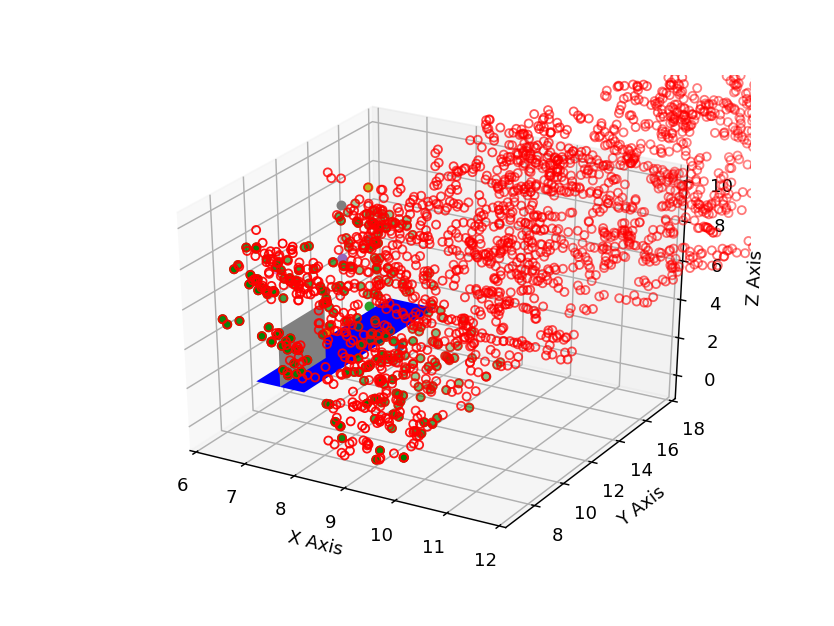

** Index grew faster than it should have? **
Index to remove: [55, 68, 86]
** Index grew faster than it should have? **
Index to remove: [55, 68, 86]
** Index grew faster than it should have? **
Index to remove: [55, 68, 86]
** Index grew faster than it should have? **
Index to remove: [55, 69, 86]
** Index grew faster than it should have? **
Index to remove: [55, 70, 86]
** Index grew faster than it should have? **
Index to remove: [55, 70, 86]
** Index grew faster than it should have? **
Index to remove: [55, 70, 86]
** Index grew faster than it should have? **
Index to remove: [55, 70, 86]
** Index grew faster than it should have? **
Index to remove: [55, 70, 86]
** Index grew faster than it should have? **
Index to remove: [56, 70, 86]
** Index grew faster than it should have? **
Index to remove: [57, 70, 86]
** Index grew faster than it should have? **
Index to remove: [57, 71, 86]
** Index grew faster than it should have? **
Index to remove: [57, 71, 86]
** Index grew faster than

In [52]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 20 == 0:
        ax.clear()
        
        try:
            for rows in range(num_row_arms):
                # check if any fruit was picked at this time
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
        except IndexError:
            print("** Index grew faster than it should have? **")
            print("Index to remove:", index_rem)
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])

        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [64]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[]
ROW 1
[]
ROW 2
[]
